In [2]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler # normalizer
import tensorflow as tf
from tensorflow import keras
import yfinance
from keras.models import Sequential
import datetime
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


In [3]:
current_date = datetime.date.today()
yesterday = current_date - datetime.timedelta(days=1)
df = yfinance.download('OLECTRA.NS', start='2016-01-01', end=current_date)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-01,19.900000,20.799999,19.600000,20.100000,20.086821,117068
2016-01-04,19.299999,20.799999,18.750000,19.950001,19.936920,112623
2016-01-05,19.950001,20.299999,19.350000,19.950001,19.936920,40011
2016-01-06,20.700001,20.700001,19.299999,19.650000,19.637115,49745
2016-01-07,20.000000,21.450001,19.200001,20.049999,20.036852,115716
...,...,...,...,...,...,...
2023-06-27,938.500000,969.900024,938.500000,952.299988,952.299988,1596193
2023-06-29,952.299988,952.299988,952.299988,952.299988,952.299988,0
2023-06-30,960.500000,1006.849976,960.000000,972.200012,972.200012,3398740


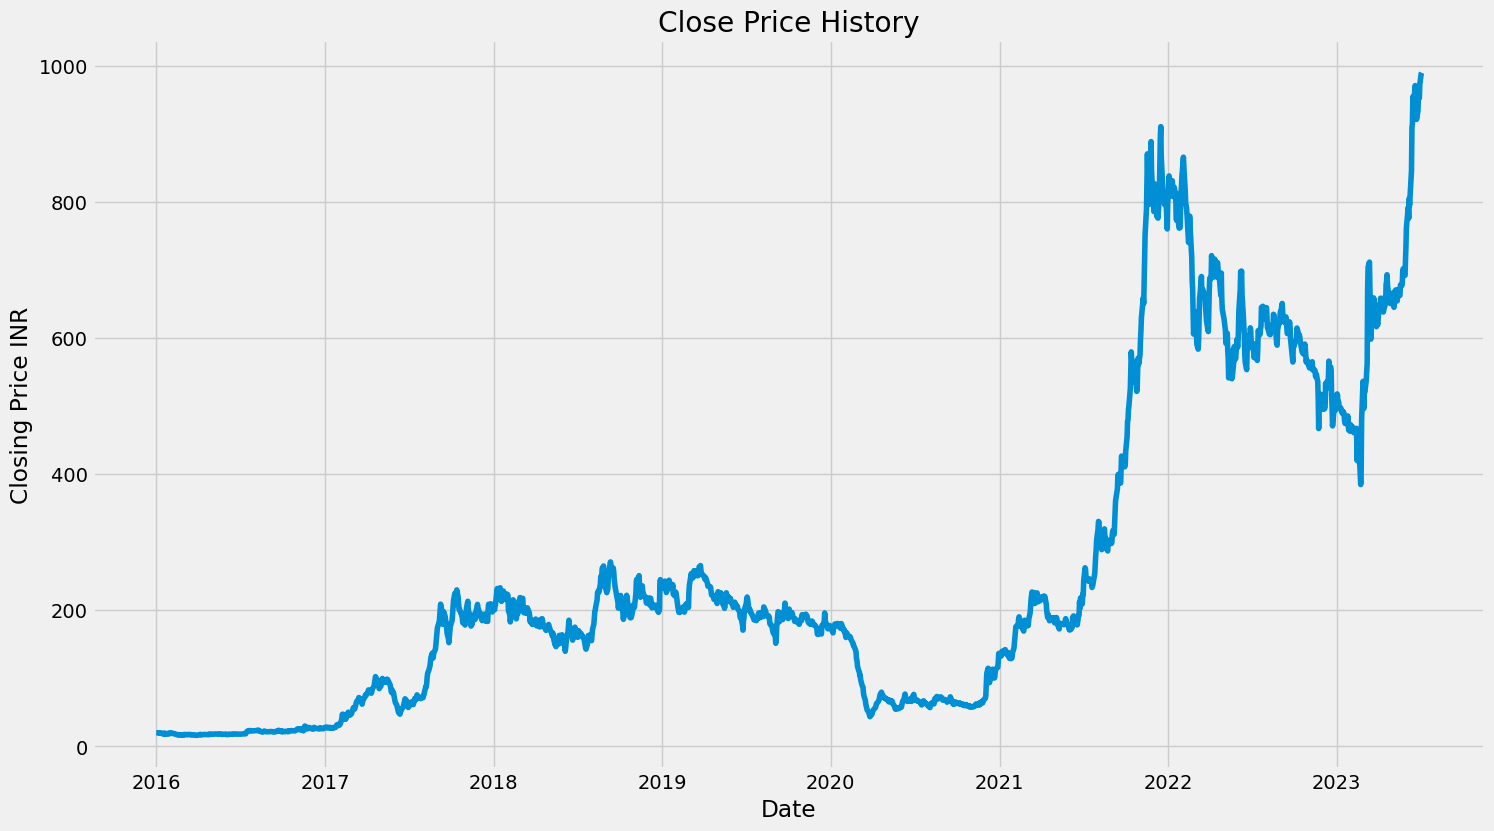

In [4]:
plt.figure(figsize=(16, 9))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Price INR')
plt.show()

In [5]:
data = df.filter(['Close'])
dataset = data.values
train_data_len = math.ceil(len(dataset) * 0.8)
train_data_len

1484

In [6]:
minmaxscaler = MinMaxScaler(feature_range=(0, 1))
standardscaler = StandardScaler()
minmax_scaled_data = minmaxscaler.fit_transform(dataset)
standard_scaled_data = standardscaler.fit_transform(dataset)

In [7]:
train_data = standard_scaled_data[:train_data_len, :]

train_data

array([[-1.00492245],
       [-1.00556392],
       [-1.00556392],
       ...,
       [ 2.32173242],
       [ 2.4923631 ],
       [ 2.46477991]])

In [8]:
X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i - 60 : i, 0])
    y_train.append(train_data[i, 0])

In [9]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((1424, 60), (1424,))

In [10]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1424, 60, 1)

In [11]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

2023-07-05 13:44:37.980549: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 13:44:37.981223: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [12]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
model.fit(X_train, y_train, batch_size=1, epochs=15)

In [14]:
test_data = standard_scaled_data[train_data_len - 60:, :]
X_test = []
y_test = dataset[train_data_len:, :]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predictions = model.predict(X_test)
predictions = standardscaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
rmse

<ipython-input-74-2f9587c969d2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


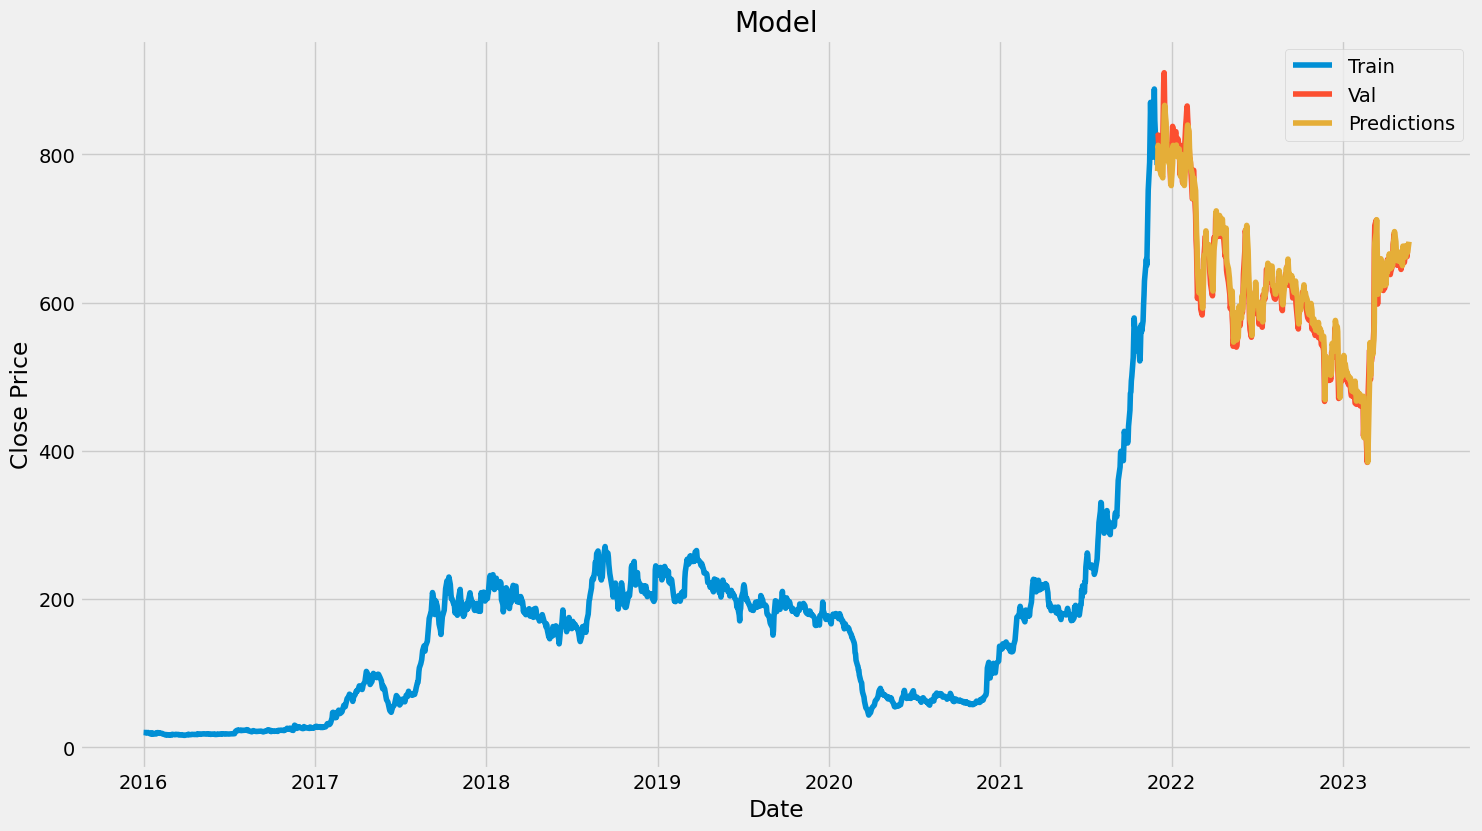

In [74]:
train = data[:train_data_len]
valid = data[train_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 9))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'])
plt.show()

In [75]:
valid

,Close,Predictions
Date,,
2021-12-02,824.900024,777.687744
2021-12-03,826.250000,812.356079
2021-12-06,795.549988,803.426086
2021-12-07,780.549988,785.589417
2021-12-08,777.599976,777.052063
...,...,...
2023-05-16,665.799988,677.047119
2023-05-17,662.900024,668.841797
2023-05-18,662.299988,668.781006


In [76]:
quote = yfinance.download('OLECTRA.NS', start='2016-01-01', end=current_date)
new_df = quote.filter(['Close'])

last_60_days = new_df[-60:].values

last_60_days_scaled = standardscaler.transform(last_60_days)

X_test = []
X_test.append(last_60_days_scaled)

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_price = model.predict(X_test)

pred_price = standardscaler.inverse_transform(pred_price)
print(pred_price)

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 26ms/step
[[679.101]]


In [ ]:
model.save('stock_tomorrow.model')